In [5]:
from distutils.command.install import install
import pandas as pd
import datetime 
from datetime import timedelta
import matplotlib.pyplot as plt
import warnings
import  scipy.signal.signaltools
import seaborn as sns
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
import numpy as np
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.arima import AutoARIMA
from IPython.display import display_html
from itertools import chain,cycle
from darts.models import Theta, FourTheta, TBATS
from darts.metrics import mape
from darts import TimeSeries
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
mse=MeanSquaredError()
rmse = MeanSquaredError(square_root=True)
from darts.metrics import mape as mape_theta,mae as mae_theta,rmse as rmse_theta,mse as mse_theta
import matplotlib.dates as mdates

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

# Prediccion del precio del GN

Actualmente el consumo de energía e españa se compone de un 24.7% de GN (statista 2022)

In [6]:
gasn = pd.read_csv('clean_data/gasnatural.csv')

In [16]:
gasn

,Unnamed: 0,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,0,2023-05-30,2.317,2.347,2.372,2.308,NaN,"-1,36%"
1,1,2023-05-29,2.349,2.434,2.447,2.338,NaN,"-3,53%"
2,2,2023-05-28,2.435,2.418,2.441,2.417,NaN,"11,65%"
3,3,2023-05-26,2.181,2.292,2.298,2.143,"2,17K","-5,46%"
4,4,2023-05-25,2.307,2.413,2.441,2.258,"48,66K","-3,79%"
...,...,...,...,...,...,...,...,...
2474,2474,2014-01-07,4.299,4.308,4.430,4.262,"159,42K","-0,16%"
2475,2475,2014-01-06,4.306,4.313,4.379,4.266,"91,96K","0,05%"
2476,2476,2014-01-03,4.304,4.298,4.390,4.206,"141,97K","-0,39%"
2477,2477,2014-01-02,4.321,4.232,4.331,4.213,"98,00K","2,10%"


In [29]:
gasn['Fecha'] = pd.to_datetime(gasn['Fecha'])

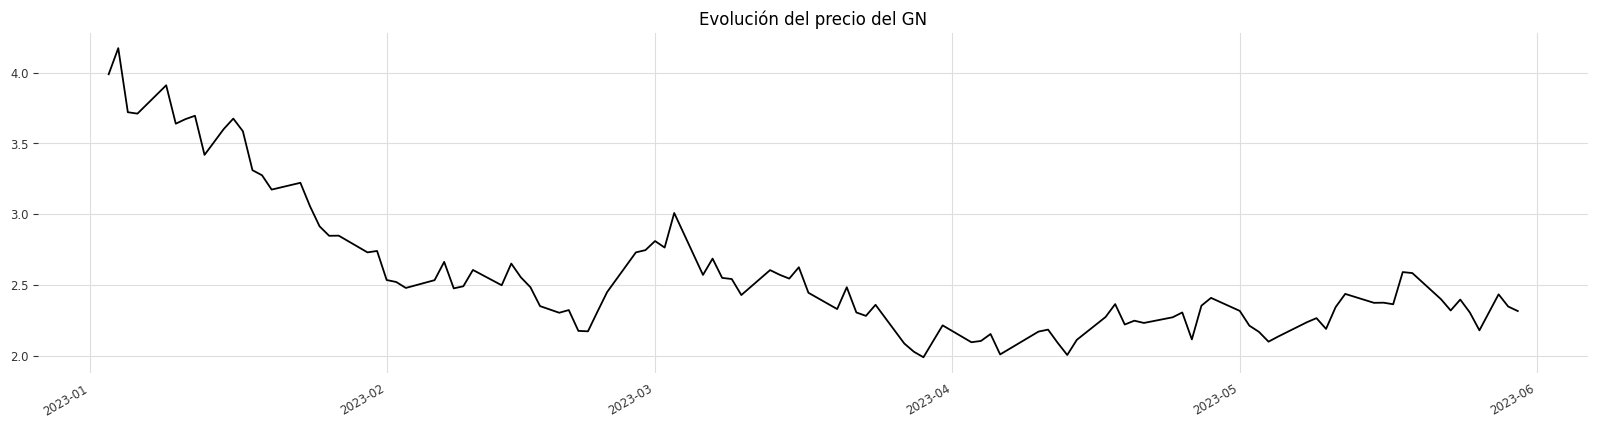

In [30]:
datos_tot = gasn.copy()
datos_tot = datos_tot.reset_index()



date_total = datos_tot["Fecha"][:108]
value_total = datos_tot["Último"][:108]

fig, ax = plt.subplots(figsize=(20, 5))

half_year_locator = mdates.MonthLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m")

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter) 

ax.axes.set_title('Evolución del precio del GN')

ax.plot(date_total, value_total)
fig.autofmt_xdate();

In [42]:
gasn_con_index=gasn.set_index('Fecha')

from datetime import datetime, timedelta

df_gn_TS=pd.DataFrame()
df_gn_TS['Date']=pd.date_range(datetime(2014,1,1), datetime(2023,5,30))
df_gn_TS=df_gn_TS.set_index('Date')

df_gn_TS = df_gn_TS.join(gasn_con_index['Último']).sort_index().fillna(method='ffill')
df_gn_TS.tail(10)

,Último
Date,
2023-05-21,2.585
2023-05-22,2.400
2023-05-23,2.321
2023-05-24,2.398
2023-05-25,2.307
2023-05-26,2.181
2023-05-27,2.181
2023-05-28,2.435
2023-05-29,2.349


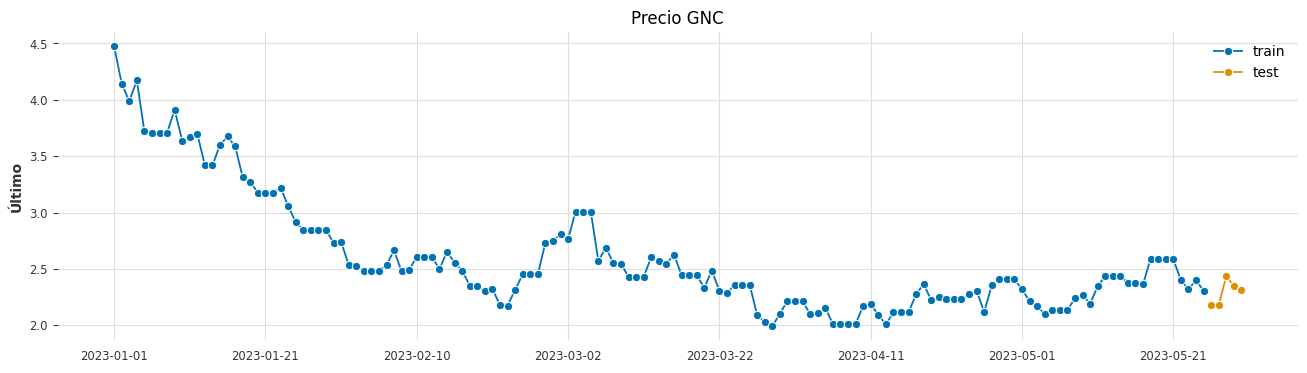

In [118]:
from sktime.utils.plotting import plot_series


data_GNC_train = df_gn_TS.loc['2023-01-01':'2023-05-25']['Último'].to_period('d')
data_GNC_test = df_gn_TS.loc['2023-05-26':]['Último'].to_period('d')

plot_series(data_GNC_train, data_GNC_test, labels=["train", "test"])
plt.title('Precio GNC');

In [121]:
from sktime.forecasting.ets import AutoETS

fh_ets = np.arange(1, 5)
ETS = AutoETS(auto=True, n_jobs=-1)
ETS.fit(data_GNC_train)

ETS_pred = ETS.predict(fh_ets)
ETS_ints_pred = ETS.predict_interval(fh_ets, coverage=0.9)

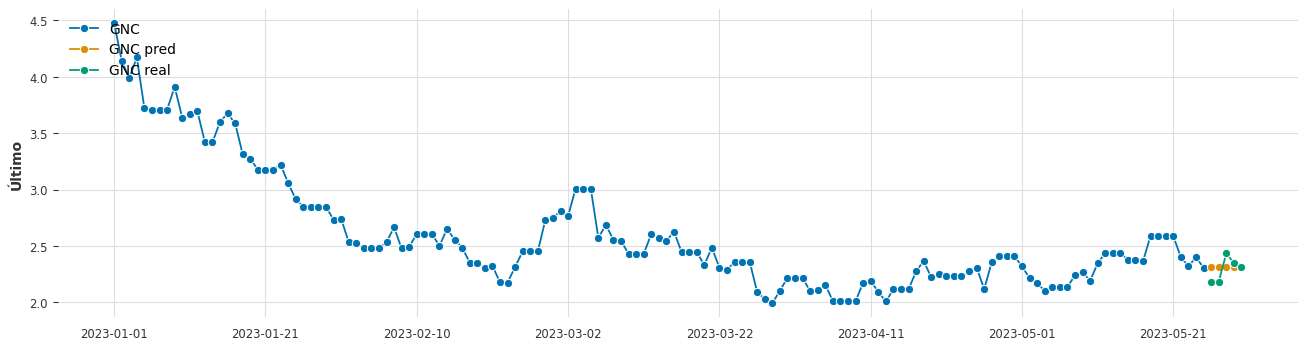

In [122]:
fig, ax = plot_series(data_GNC_train['2023-01-01':], ETS_pred, data_GNC_test, labels=["GNC", "GNC pred", "GNC real"])

ax.legend(loc='upper left');

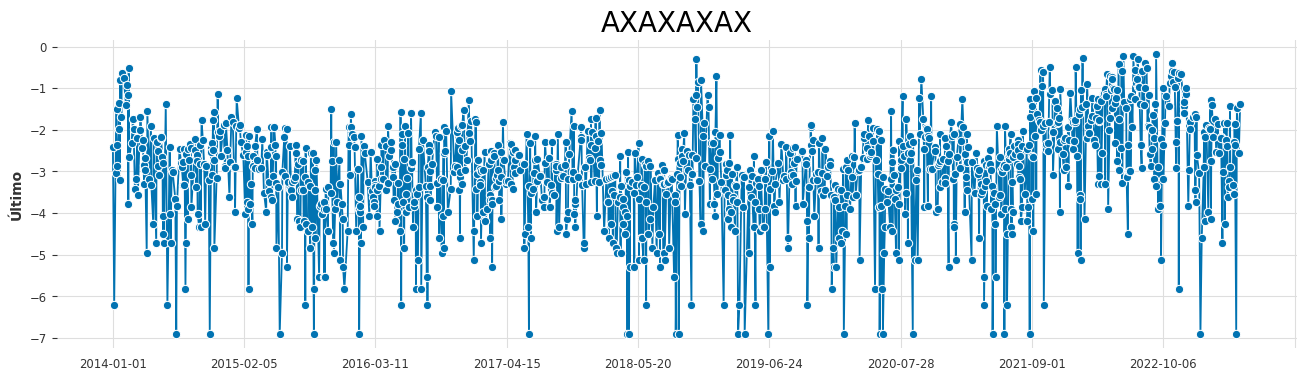

In [94]:
data_log_t1a=pd.DataFrame(LogTransformer().fit_transform(df_gn_TS['Último'].diff()))
data_log_t1a.rename(columns = {0:'Último'}, inplace = True)
plot_series(data_log_t1a['Último'].to_period('d'))
difference_log = data_log_t1a.diff(axis=0).dropna()
plt.title("AXAXAXAX",fontsize=20);

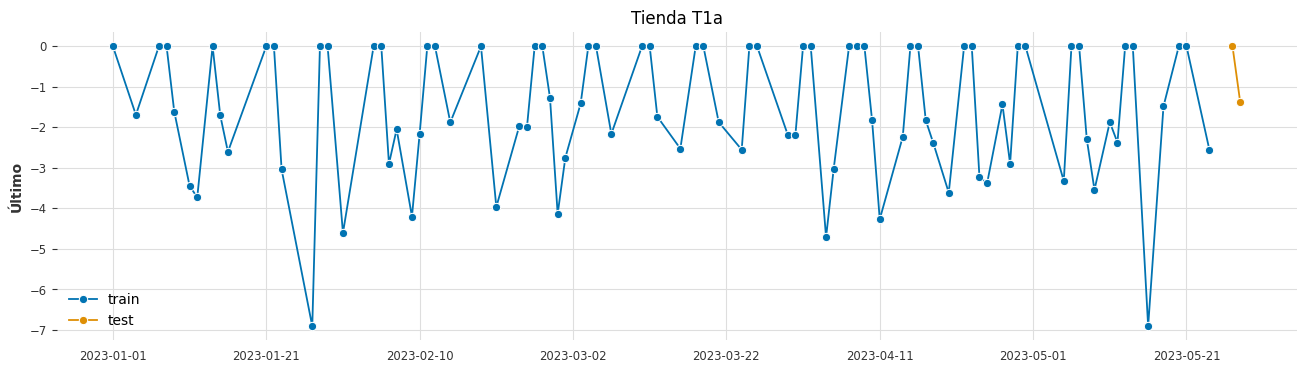

In [101]:
data_log_t1a.replace(-np.inf,0,inplace=True)

data_t1a_log_train = data_log_t1a.loc['2023-01-01':'2023-05-25']['Último'].to_period('d')
data_t1a_log_test = data_log_t1a.loc['2023-05-25':]['Último'].to_period('d')

plot_series(data_t1a_log_train, data_t1a_log_test, labels=["train", "test"])
plt.title('Tienda T1a');

In [100]:
fh_arima = np.arange(1, 5)
ARIMA_log_t1a = AutoARIMA(sp=3,suppress_warnings=True)
ARIMA_log_t1a.fit(data_t1a_log_train)
log_y_pred_arima_t1a = pd.DataFrame(ARIMA_log_t1a.predict(fh_arima))

ValueError: Input contains NaN.

In [87]:
log_y_pred_arima_t1a

,Último
2023-05-26,0.835948
2023-05-27,0.835948
2023-05-28,0.835948
2023-05-29,0.835948


In [ ]:
plot_series(df_gn_TS["2023-01-01":], np.exp(log_y_pred_arima_t1a),data_GNC_test, labels=["train_t1a", "pred_t1a", "test_t1a"])
plt.title("ARIMA con logaritmos de T1a",fontsize=20);

In [106]:
data_GNC_train

2023-01-01    4.475
2023-01-02    4.143
2023-01-03    3.988
2023-01-04    4.172
2023-01-05    3.720
              ...  
2023-05-21    2.585
2023-05-22    2.400
2023-05-23    2.321
2023-05-24    2.398
2023-05-25    2.307
Freq: D, Name: Último, Length: 145, dtype: float64

In [114]:
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(y = data_GNC_train, 
                             start_p=0, 
                             start_q=0,
                             test='adf',
                             max_p=5, 
                             max_q=5,
                             m=1,
                             d=None,
                             start_P=0, 
                             D=0, 
                             trace=True,
#                              error_action='ignore',  
#                              suppress_warnings=True, 
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-200.447, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-200.584, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-200.699, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-200.159, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-198.727, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-198.734, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-196.707, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-199.835, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.480 seconds


In [116]:
from statsmodels.tsa.arima.model  import ARIMA
model = ARIMA(data_GNC_train, order=(1,1,0))  # using p=1, d=1, q=0
fitted = model.fit() 
fc, se, conf = fitted.forecast(data_GNC_test.shape[0]-2, alpha=0.05) 

In [117]:
fc

2.316953832500776

In [108]:
fc_series = pd.Series(fc, index=test_data['Date'])
lower_series = pd.Series(conf[:, 0], index=test_data['Date'])
upper_series = pd.Series(conf[:, 1], index=test_data['Date'])


# plot all the series together
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data['Date'], train_data['Close'], label='Training data')
plt.plot(test_data['Date'], test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)

plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()